<font size='4'><b>Problem statement:</b> In the television documentary “Ross Kemp and the Armed Police” broadcast 6th September 2018 by ITV, multiple claims were made regarding violent crime in the UK.<br/><br/>
These claims were:
1.	Violent Crime is increasing
2.	There are more firearms incidents per head in Birmingham than anywhere else in the UK
3.	Crimes involving firearms are closely associated with drugs offences<br/><br/>
In this assignment you will investigate these claims using real, publicly available data sets that will be made available to you and placed in Amazon S3. </font>

<br/><br/>

In [0]:
# Importing libraries.
from pyspark.sql.functions import count,col
import pyspark.sql.functions as func

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Reading the text file.
txt=sc.textFile("FileStore/tables/crimes_2018_only_txt.gz")
# Assigning the first line to header.

##### Note: 2018 dataset does not have header, we need to set it manually.

In [0]:
header='Crime_ID,Month,Reported_by,Falls_within,Longitude,Latitude,Location,LSOA_code,LSOA_name,Crime_type,Last_outcome_category,Context'

In [0]:
txt.take(10)

Out[5]: ['4b89599348c51bcc80abf2fab1e55537b9f5473e9cd654259681be101beda819,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,0.489518,51.560445,On or near Whytewaters,E01021311,Basildon 022C,Other crime,Investigation complete; no suspect identified,',
 ',2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 '74128ab275c1aa107d67cd59d1d3210bd9fdc976e0c2c6b6aad058a9ef3f4e8d,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Burglary,Status update unavailable,',
 '0417b3f4363b480f4d4c2a826be8cd4a957fffb818873e73bf3662698e2d734c,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515816,51.408717,On or near Caroline Close,E01014399,Bath and North East Somerset 001A,Criminal damage and arson,Further investigation is not in the public interest,',
 '0a404693ae14efee16186c98d4e63d5f2d1fc29d5efb1e317ce3e8a8e5f49733,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494870,51.422276,On or near Conference/Exhibition Centre,E01014399,Bath and North East Somerset 001A,Criminal damage and arson,Status update unavailable,',
 '2f02418280c300288de3aec278619e2b0fcfc8c83e7ffe552504660f489a4683,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.495055,51.422132,On or near Cross Street,E01014399,Bath and North East Somerset 001A,Criminal damage and arson,Status update unavailable,',
 '32260926ecfec610aee50ab09c8041610df9b67c78034b1309bec610d4fb2aaf,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.512773,51.411751,On or near Westfield Close,E01014399,Bath and North East Somerset 001A,Other theft,Status update unavailable,',
 'd1570aef4546eb5ae4e8b1976db9e0d009ca531f9bb642ab03a8def8231d8321,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511761,51.409966,On or near Caernarvon Close,E01014399,Bath and North East Somerset 001A,Possession of weapons,Status update unavailable,',
 'ba51a848551dbff1d99c1dcb3b2bd512b9508cda54c103c13345e748df869d82,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Public order,Status update unavailable,',
 'e36cb6ffeb39683b4406decd6706d38ac08f766e3be3dc9991ad5b6c942e410d,2018-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.513343,51.408772,On or near Lincoln Close,E01014399,Bath and North East Somerset 001A,Vehicle crime,Status update unavailable,']

##### Note: Below step is very important as data contained ',' values embedded in strings which was causing numerous errors in Schema. Here, we are rejecting all the lines which have ',' value embedded in string. i.e. we are allowing only 12 values. If after spliting, number of values is more than 12, it clearly indicats occurance of ',' within strings.

In [0]:
# Filtering corrupt data.
txt = txt.filter(lambda line: len(line.split(","))==12)

In [0]:
# Assigning split values to a temporary variable.
temp_var = txt.map(lambda k: k.split(","))

In [0]:
# Converting data in the temporary variable into a Spark dataframe.
df=temp_var.toDF(header.split(","))

In [0]:
# Taking a peek at the dataframe.
df.show(10)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
 Crime_ID| Month| Reported_by| Falls_within|Longitude| Latitude| Location|LSOA_code| LSOA_name| Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
4b89599348c51bcc8...|2018-01|Avon and Somerset...|Avon and Somerset...| 0.489518|51.560445|On or near Whytew...|E01021311| Basildon 022C| Other crime| Investigation com...| |
 |2018-01|Avon and Somerset...|Avon and Somerset...|-2.516919|51.423683| On or near A4175|E01014399|Bath and North Ea...|Anti-social behav...| | |
74128ab275c1aa107...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.515072|51.419357|On or near Stockw...|E01014399|Bath and North Ea...| Burglary| Status update una...| |
0417b3f4363b480f4...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.515816|51.408717|On or near Caroli...|E01014399|Bath and North Ea...|Criminal damage a...| Further investiga...| |
0a404693ae14efee1...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.494870|51.422276|On or near Confer...|E01014399|Bath and North Ea...|Criminal damage a...| Status update una...| |
2f02418280c300288...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.495055|51.422132|On or near Cross ...|E01014399|Bath and North Ea...|Criminal damage a...| Status update una...| |
32260926ecfec610a...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.512773|51.411751|On or near Westfi...|E01014399|Bath and North Ea...| Other theft| Status update una...| |
d1570aef4546eb5ae...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.511761|51.409966|On or near Caerna...|E01014399|Bath and North Ea...|Possession of wea...| Status update una...| |
ba51a848551dbff1d...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.515072|51.419357|On or near Stockw...|E01014399|Bath and North Ea...| Public order| Status update una...| |
e36cb6ffeb39683b4...|2018-01|Avon and Somerset...|Avon and Somerset...|-2.513343|51.408772|On or near Lincol...|E01014399|Bath and North Ea...| Vehicle crime| Status update una...| |
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
only showing top 10 rows

In [0]:
# Droping columns which have no value as a part of data cleaning.
df_new=df.drop('Crime_ID','Last_outcome_category','Context')

In [0]:
# Observing the schema of dataframe.
df_new.printSchema()

root
-- Month: string (nullable = true)
-- Reported_by: string (nullable = true)
-- Falls_within: string (nullable = true)
-- Longitude: string (nullable = true)
-- Latitude: string (nullable = true)
-- Location: string (nullable = true)
-- LSOA_code: string (nullable = true)
-- LSOA_name: string (nullable = true)
-- Crime_type: string (nullable = true)

##### Note: Here, all variables are strings. But we know that 'Month' should take date type and Longitude & Longitudes should take double type

In [0]:
# Converting these three variables into required types.
df_new=df_new.withColumn("Month",df['Month'].cast("date"))
df_new=df_new.withColumn("Longitude",df['Longitude'].cast("double"))
df_new=df_new.withColumn("Latitude",df['Latitude'].cast("double"))

In [0]:
# Checking the schema again.
df_new.printSchema()
# Awesome, we are now ready with formatted data.

root
-- Month: date (nullable = true)
-- Reported_by: string (nullable = true)
-- Falls_within: string (nullable = true)
-- Longitude: double (nullable = true)
-- Latitude: double (nullable = true)
-- Location: string (nullable = true)
-- LSOA_code: string (nullable = true)
-- LSOA_name: string (nullable = true)
-- Crime_type: string (nullable = true)

##### Let's see the descriptive statistics

In [0]:
# Statistical analysis of variables.
df_new.describe().show()

+-------+--------------------+--------------------+-------------------+------------------+--------------------+---------+---------+--------------------+
summary| Reported_by| Falls_within| Longitude| Latitude| Location|LSOA_code|LSOA_name| Crime_type|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+---------+---------+--------------------+
 count| 3817213| 3817213| 3730793| 3730793| 3817213| 3817213| 3817213| 3817213|
 mean| null| null|-1.4306233665304802| 52.51485366331499| null| null| null| null|
 stddev| null| null| 1.4514040048191166|1.1993739701536836| null| null| null| null|
 min|Avon and Somerset...|Avon and Somerset...| -8.135559| 49.89292| No Location| | |Anti-social behav...|
 max| Wiltshire Police| Wiltshire Police| 1.759519| 57.642917|On or near Zurich...|W01001958|York 024F|Violence and sexu...|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+---------+---------+--------------------+

##### Claim-1: Violent crimes are increasing in UK.

In [0]:
# Let's see the number of crime types in UK.
df_new.groupby('Crime_type').count().show()

+--------------------+-------+
 Crime_type| count|
+--------------------+-------+
 Bicycle theft| 51163|
 Public order| 252815|
 Drugs| 82235|
 Other crime| 59931|
 Robbery| 46068|
Criminal damage a...| 338520|
Theft from the pe...| 56199|
 Shoplifting| 223030|
 Burglary| 241708|
 Other theft| 316736|
Possession of wea...| 26646|
Violence and sexu...|1015269|
 Vehicle crime| 261493|
Anti-social behav...| 845400|
+--------------------+-------+

In [0]:
# Creating a temporary table for SQL queries. Table name is Crime_UK.
temp_table_name = "Crime_UK"
df_new.createOrReplaceTempView(temp_table_name)

##### Note: The above table is temporary and availabe only during this run time

In [0]:
# Just see how the table is.
%sql
select * from Crime_UK limit 3;

Month,Reported_by,Falls_within,Longitude,Latitude,Location,LSOA_code,LSOA_name,Crime_type
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,0.489518,51.560445,On or near Whytewaters,E01021311,Basildon 022C,Other crime
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Burglary


In [0]:
# This is an important funtion used throughtout the code for count aggregation.
import pyspark.sql.functions as F

cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

In [0]:
# Analyzing both types of violent crimes: 'Violent crime' and 'Violence and sexual offences'.
%sql 
select * from Crime_UK where Crime_type=='Violent crime'or Crime_type=='Violence and sexual offences' order by Month limit 3;

Month,Reported_by,Falls_within,Longitude,Latitude,Location,LSOA_code,LSOA_name,Crime_type
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.495055,51.422132,On or near Cross Street,E01014399,Bath and North East Somerset 001A,Violence and sexual offences
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Violence and sexual offences
2018-01-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511761,51.409966,On or near Caernarvon Close,E01014399,Bath and North East Somerset 001A,Violence and sexual offences


##### Note: Here I am considering 'Violent Crime' and 'Violence and sexual offences' as violent crimes for the problem statement. I am not considering robbery

In [0]:
df_time_series=df_new.groupBy('Month').agg(cnt_cond(F.col('Crime_type').isin(['Violent crime', 'Violence and sexual offences'])).alias('count'))
df_time_series.show(3)

+----------+------+
 Month| count|
+----------+------+
2018-02-01|120093|
2018-05-01|158058|
2018-07-01|166576|
+----------+------+
only showing top 3 rows

In [0]:
# Converting spark dataframe into pandas dataframe to leverage matplotlib.
pdf = (
    df_time_series.select(
        "Month",
        "count")
    .orderBy("Month")
    .toPandas()
)

In [0]:
# Calculating rolling average by keeping window as 2.
pdf['rolling average'] = pdf['count'].rolling(2).mean().shift(-1)
pdf['rolling average'].head(3)

Out[26]: 0 125732.5
1 130528.5
2 141539.5
Name: rolling average, dtype: float64

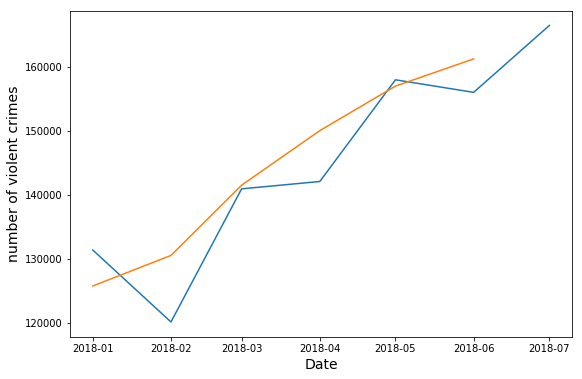

In [0]:
plt.figure(figsize=(9,6))
# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="Month",y="count",
             data=pdf,
             ci=None)
sns.lineplot(x="Month",y="rolling average",
             data=pdf,
             ci=None)

plt.xlabel("Date", size=14)
plt.ylabel("number of violent crimes", size=14)

##### Validation of claim-1: Violent crime rate took a dip in February 2018. However, it started to increase afterwards barring a only little decrease in June. It can be clearly proved that violent crimes are increasing in UK. February decrease is possibly due to reduction is the temperature. Increase in crime rate with increasing temperature is a proven phenomenon in cold countries across the globe.

##### Claim-2: There are more firearm incidents per head in Birmingham than anywhere else in UK

In [0]:
df1 = spark.read.format("csv")\
  .option("inferSchema", "true") \
  .option("header", "true") \
  .option("sep", ',')\
  .load("dbfs:/FileStore/shared_uploads/manoharkaranth95@gmail.com/LSOA_pop_v2.csv") 
df1.show(3)


+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
date| geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
2011|Darlington 001B| E01012334| Total| 2466| 1220| 1246| 2466| 0| 42| 6033.58| 0.4|
2011|Darlington 001C| E01012335| Total| 1383| 682| 701| 1383| 0| 21| 114.01| 12.1|
2011|Darlington 001D| E01012366| Total| 2008| 972| 1036| 2008| 0| 30| 6718.16| 0.3|
+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
only showing top 3 rows

In [0]:
print(df1.columns)

['date', 'geography', 'geography code', 'Rural Urban', 'Variable: All usual residents; measures: Value', 'Variable: Males; measures: Value', 'Variable: Females; measures: Value', 'Variable: Lives in a household; measures: Value', 'Variable: Lives in a communal establishment; measures: Value', 'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value', 'Variable: Area (Hectares); measures: Value', 'Variable: Density (number of persons per hectare); measures: Value']

In [0]:
# Renaming required columns.
df1= df1.withColumnRenamed('Variable: All usual residents; measures: Value', 'Number_of_People')
df1= df1.withColumnRenamed('Variable: Males; measures: Value', 'Number_of_Males')
df1= df1.withColumnRenamed('Variable: Females; measures: Value','Number_of_Females')
df1.show(3)


+----+---------------+--------------+-----------+----------------+---------------+-----------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
date| geography|geography code|Rural Urban|Number_of_People|Number_of_Males|Number_of_Females|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+---------------+--------------+-----------+----------------+---------------+-----------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
2011|Darlington 001B| E01012334| Total| 2466| 1220| 1246| 2466| 0| 42| 6033.58| 0.4|
2011|Darlington 001C| E01012335| Total| 1383| 682| 701| 1383| 0| 21| 114.01| 12.1|
2011|Darlington 001D| E01012366| Total| 2008| 972| 1036| 2008| 0| 30| 6718.16| 0.3|
+----+---------------+--------------+-----------+----------------+---------------+-----------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
only showing top 3 rows

In [0]:
# Slicing the dataframe keeping only required data.
df1_sel=df1.select(['geography code','Number_of_People'])
df1_sel.show(3)

+--------------+----------------+
geography code|Number_of_People|
+--------------+----------------+
 E01012334| 2466|
 E01012335| 1383|
 E01012366| 2008|
+--------------+----------------+
only showing top 3 rows

In [0]:
df1_sel.printSchema()

root
-- geography code: string (nullable = true)
-- Number_of_People: integer (nullable = true)

In [0]:
df1_sel= df1_sel.withColumnRenamed('geography code', 'LSOA_code')

In [0]:
# Slicing the crime dataframe.
df_sel=df_new.select(['Month','LSOA_code', 'LSOA_name','Crime_type'])
df_sel.show(3)


+----------+---------+--------------------+--------------------+
 Month|LSOA_code| LSOA_name| Crime_type|
+----------+---------+--------------------+--------------------+
2018-01-01|E01021311| Basildon 022C| Other crime|
2018-01-01|E01014399|Bath and North Ea...|Anti-social behav...|
2018-01-01|E01014399|Bath and North Ea...| Burglary|
+----------+---------+--------------------+--------------------+
only showing top 3 rows

In [0]:
df_sel = df_sel.withColumn("LSOA_6", df_sel.LSOA_name.substr(1,6))
df_sel.show(3)

+----------+---------+--------------------+--------------------+------+
 Month|LSOA_code| LSOA_name| Crime_type|LSOA_6|
+----------+---------+--------------------+--------------------+------+
2018-01-01|E01021311| Basildon 022C| Other crime|Basild|
2018-01-01|E01014399|Bath and North Ea...|Anti-social behav...|Bath a|
2018-01-01|E01014399|Bath and North Ea...| Burglary|Bath a|
+----------+---------+--------------------+--------------------+------+
only showing top 3 rows

In [0]:
# Merging crime and LSOA slices
df_joined= df_sel.join(df1_sel, on='LSOA_code', how='left_outer')
df_joined.show(3)


+---------+----------+--------------------+--------------------+------+----------------+
LSOA_code| Month| LSOA_name| Crime_type|LSOA_6|Number_of_People|
+---------+----------+--------------------+--------------------+------+----------------+
E01021311|2018-01-01| Basildon 022C| Other crime|Basild| 1349|
E01014399|2018-01-01|Bath and North Ea...|Anti-social behav...|Bath a| 1624|
E01014399|2018-01-01|Bath and North Ea...| Burglary|Bath a| 1624|
+---------+----------+--------------------+--------------------+------+----------------+
only showing top 3 rows

In [0]:
df_firearm=df_joined.groupBy('LSOA_6').agg(
    cnt_cond(F.col('Crime_type').isin(['Possession of weapons', 'Public disorder and weapons'])).alias('y_cnt'))
df_firearm.show(3)

+------+-----+
LSOA_6|y_cnt|
+------+-----+
Carlis| 39|
Charnw| 76|
Leeds | 449|
+------+-----+
only showing top 3 rows

In [0]:
df_population = df_joined.groupby("LSOA_6").\
    agg(
        func.sumDistinct("Number_of_People").alias("total_population")
    )



In [0]:
# look at the population data and cross check on internet.
df_population.show(3)
# Population data is validated through internet information.

+------+----------------+
LSOA_6|total_population|
+------+----------------+
Carlis| 100866|
Charnw| 154546|
Leeds | 539479|
+------+----------------+
only showing top 3 rows

In [0]:
# Joining population and firearms dataframes.
df_per_capita= df_firearm.join(df_population, on='LSOA_6', how='left_outer')
df_per_capita.show(3)

+------+-----+----------------+
LSOA_6|y_cnt|total_population|
+------+-----+----------------+
Carlis| 39| 100866|
Charnw| 76| 154546|
Leeds | 449| 539479|
+------+-----+----------------+
only showing top 3 rows

In [0]:
# Calculating firearm incidents per head.
df_per_capita=df_per_capita.withColumn('per_head', df_per_capita['y_cnt']/df_per_capita['total_population'])

In [0]:
df_per_capita.show(3)

+------+-----+----------------+--------------------+
LSOA_6|y_cnt|total_population| per_head|
+------+-----+----------------+--------------------+
Carlis| 39| 100866|3.866515971685206E-4|
Charnw| 76| 154546|4.917629702483403E-4|
Leeds | 449| 539479|8.322844818797395E-4|
+------+-----+----------------+--------------------+
only showing top 3 rows

In [0]:
# Converting into pandas dataframe.
pdf1 = (
    df_per_capita.select(
        "LSOA_6",
        "per_head")
    .orderBy("per_head")
    .toPandas()
)

In [0]:
# Looking at top 30 highest firearm/ person regions.
pdf1.tail(30)

,LSOA_6,per_head
280,Leeds,0.000832
281,Birmin,0.000834
282,Tower,0.000838
283,Southa,0.000838
284,Newcas,0.000849
285,Oldham,0.000877
286,Windso,0.000900
287,Haring,0.000906
288,Tamesi,0.000978
289,Bright,0.000982


In [0]:
# Let's select only top 30 out of 309 LSOA for easy dipiction.
pdf_sel=pdf1.iloc[-30:,:]
pdf_sel.head(3)

,LSOA_6,per_head
280,Leeds,0.000832
281,Birmin,0.000834
282,Tower,0.000838


In [0]:
# Converting into crime per 10,000 for easy visualisation. pdf_sel["per_ten_thousand"]=pdf_sel['per_head']*10000.
pdf_sel.head(3)

,LSOA_6,per_head,per_ten_thousand
280,Leeds,0.000832,8.322845
281,Birmin,0.000834,8.344626
282,Tower,0.000838,8.382581


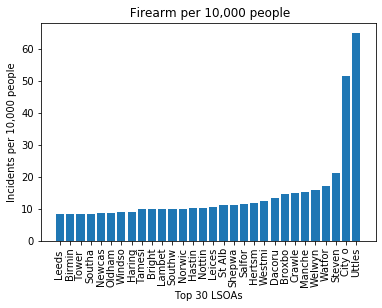

In [0]:
plt.bar(pdf_sel.LSOA_6,pdf_sel.per_ten_thousand)
plt.xticks(rotation=90)
plt.title(" Firearm per 10,000 people")
plt.xlabel("Top 30 LSOAs")
plt.ylabel('Incidents per 10,000 people')

##### Validation of claim-2: By looking at the bar plot, Birmingham holds 29th position in UK out of 309 LSOAs in terms of fire arm incidents per head. So, we can clearly reject the claim made in ITV documentary. Uttlesford is holding the first position with 64 incidents per 10,000 people. City of London which is arguably the most metropolitan city in UK seems to be following US culture being second only to Uttlesford.

#### Claim-3: Crimes involving firearms are closely associated with drugs offences

In [0]:
# A dataframe for LSOA wise drug incidents.
df_drugs=df_joined.groupBy('LSOA_6').agg(cnt_cond(F.col('Crime_type') =='Drugs').alias('drugs_count'))
df_drugs.show(3)

+------+-----------+
LSOA_6|drugs_count|
+------+-----------+
Carlis| 166|
Charnw| 147|
Leeds | 1226|
+------+-----------+
only showing top 3 rows

In [0]:
# Joining firearm and drug dataset for further analysis.
df_final= df_firearm.join(df_drugs, on='LSOA_6', how='left_outer')
df_final.show(3)

+------+-----+-----------+
LSOA_6|y_cnt|drugs_count|
+------+-----+-----------+
Carlis| 39| 166|
Charnw| 76| 147|
Leeds | 449| 1226|
+------+-----+-----------+
only showing top 3 rows

In [0]:
# Renaming the firearm count column.
df_final= df_final.withColumnRenamed('y_cnt','firearms_count')
df_final.show(3)

+------+--------------+-----------+
LSOA_6|firearms_count|drugs_count|
+------+--------------+-----------+
Carlis| 39| 166|
Charnw| 76| 147|
Leeds | 449| 1226|
+------+--------------+-----------+
only showing top 3 rows

In [0]:
# Let's check Pearson correlation first.
df_final.stat.corr('firearms_count','drugs_count')

Out[86]: 0.8576224694459892

In [0]:
# Converting into pandas dataframe.
pdf2 = (
    df_final.select(
        "firearms_count",
        "drugs_count")
    .toPandas()
)

In [0]:
# Spearman correlation.
pdf2.corr(method='spearman', min_periods=1)

,firearms_count,drugs_count
firearms_count,1.000000,0.838724
drugs_count,0.838724,1.000000


In [0]:
pdf2_sel=pdf2[pdf2['firearms_count']<1000]

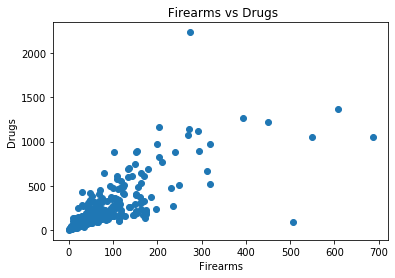

In [0]:
plt.scatter(pdf2_sel.firearms_count,pdf2_sel.drugs_count)
plt.title(" Firearms vs Drugs")
plt.xlabel("Firearms")
plt.ylabel('Drugs')

In [0]:
plt.close()

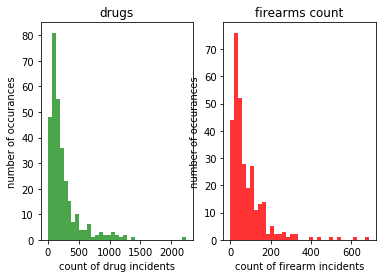

In [0]:
# Plotting histograms for comparison.
fig, ax = plt.subplots(1,2)
ax[0].hist(pdf2_sel['drugs_count'],alpha=0.7, bins=35, color='green')
ax[0].title.set_text('drugs')
ax[0].set_xlabel('count of drug incidents')
ax[0].set_ylabel('number of occurances')

ax[1].title.set_text('firearms count')
ax[1].hist(pdf2_sel['firearms_count'], alpha=0.8, bins=35, color='red')
ax[1].set_xlabel('count of firearm incidents')
ax[1].set_ylabel('number of occurances')


plt.show()

In [0]:
vec = VectorAssembler(inputCols=["firearms_count", "drugs_count"], outputCol="features")
new_df = vec.transform(df_final)
new_df.show()

+------+--------------+-----------+--------------+
LSOA_6|firearms_count|drugs_count| features|
+------+--------------+-----------+--------------+
Carlis| 39| 166| [39.0,166.0]|
Charnw| 76| 147| [76.0,147.0]|
Leeds | 449| 1226|[449.0,1226.0]|
Stroud| 16| 52| [16.0,52.0]|
Cotswo| 4| 28| [4.0,28.0]|
Adur 0| 29| 40| [29.0,40.0]|
Maldon| 21| 30| [21.0,30.0]|
Harbor| 11| 24| [11.0,24.0]|
Westmi| 241| 884| [241.0,884.0]|
Bolton| 174| 226| [174.0,226.0]|
Basing| 100| 172| [100.0,172.0]|
North | 549| 1057|[549.0,1057.0]|
Swanse| 71| 454| [71.0,454.0]|
Winche| 30| 104| [30.0,104.0]|
Bromsg| 25| 90| [25.0,90.0]|
Luton | 93| 208| [93.0,208.0]|
Slough| 99| 274| [99.0,274.0]|
Amber | 29| 116| [29.0,116.0]|
Isling| 133| 687| [133.0,687.0]|
Worces| 43| 163| [43.0,163.0]|
+------+--------------+-----------+--------------+
only showing top 20 rows

In [0]:
kmeans = KMeans(k=4, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

In [0]:
transformed = model.transform(new_df)
transformed.show(3)  

+------+--------------+-----------+--------------+----------+
LSOA_6|firearms_count|drugs_count| features|prediction|
+------+--------------+-----------+--------------+----------+
Carlis| 39| 166| [39.0,166.0]| 1|
Charnw| 76| 147| [76.0,147.0]| 1|
Leeds | 449| 1226|[449.0,1226.0]| 3|
+------+--------------+-----------+--------------+----------+
only showing top 3 rows

##### Validation of Claim-3: A correlation of 0.85 indicates that there is a strong ralationship between firearms and drugs. So, claim 3 is justified. Further, scatter plot makes the relationship clearly visible.

<br/><br/>

<font size='4'><b>Final thoughts:</b> Using 2018 dataset, we have accepted two hypothesis and rejected one. Generally speaking, rejected hypothesis (Birmingham case) is also somewhat true as it enjoys 29th position out of 309, but it can't be called as the highest. Other two hypothesis are accurate. Violent crime's gradual increase can't be inferred as Police Forces failure alone, but can also be related to growing frustration. For this case, further research has to be made. Relationship between drugs and firearms is quite universal and only needs common sense to understand.</font>